In [11]:
%cd C:\Users\yukir\Documents\GitHub\sign_detection\py

C:\Users\yukir\Documents\GitHub\sign_detection\py


In [12]:
from basic_preprocessing import *
from deeplearning_check import *

gpu_check()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17889051713916325472
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9050893924874223095
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5729652249830952565
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1525131871410354934
physical_device_desc: "device: XLA_GPU device"
]


#### basic model

In [13]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output

C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output


In [14]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(100,100), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(100, 100), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(100, 100), color_mode='rgb')

input_tensor = Input(shape=(100, 100, 3), dtype='float32', name='input')

Found 110 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
def create_model():
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = models.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(layers.Flatten())
    additional_model.add(layers.Dense(4096, activation='relu'))
    additional_model.add(layers.Dense(2048, activation='relu'))
    additional_model.add(layers.Dense(1024, activation='relu'))
    additional_model.add(layers.Dense(2, activation='softmax'))

    additional_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

    
    return additional_model

In [18]:
# 모델 실행 옵션 
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              18878464  
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2050      
Total params: 44,084,034
Trainable params: 29,369,346
Non-trainable params: 14,714,688
_________________________________

In [19]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [20]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=10, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.7764 - acc: 0.5455
Epoch 00001: loss improved from inf to 0.77644, saving model to training_2/cp.ckpt
7/7 [==============================] - 2s 300ms/step - loss: 0.7764 - acc: 0.5455 - val_loss: 0.5772 - val_acc: 0.7692
Epoch 2/10
5/7 [====================>.........] - ETA: 0s - loss: 0.4674 - acc: 0.7625
Epoch 00002: loss improved from 0.77644 to 0.46544, saving model to training_2/cp.ckpt
7/7 [==============================] - 1s 193ms/step - loss: 0.4654 - acc: 0.7909 - val_loss: 0.4894 - val_acc: 0.8462
Epoch 3/10
5/7 [====================>.........] - ETA: 0s - loss: 0.3475 - acc: 0.9125
Epoch 00003: loss improved from 0.46544 to 0.36625, saving model to training_2/cp.ckpt
7/7 [==============================] - 1s 194ms/step - loss: 0.3663 - acc: 0.8818 - val_loss: 0.4729 - val_acc: 0.8462
Epoch 4/10
5/7 [====================>.........] -

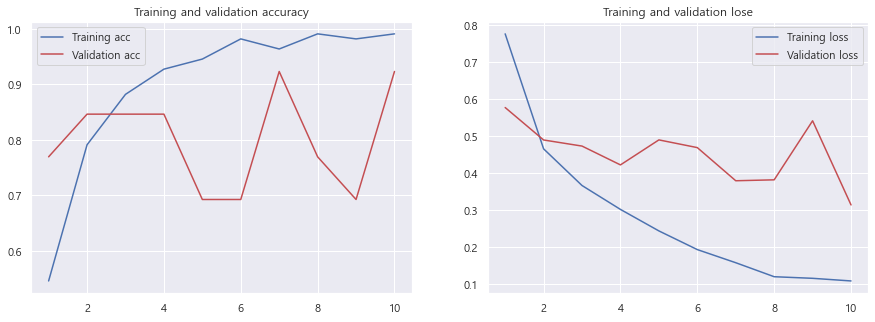

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [22]:
#맥에서는 !ls
#저장된 checkpoint확인하기
!dir {checkpoint_dir}

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 5848-7E5C

 C:\Users\yukir\Documents\Monicas_workspace\Datasets\0804\SIGN\output\output\training_2 디렉터리

2021-08-06  오전 03:51    <DIR>          .
2021-08-06  오전 03:51    <DIR>          ..
2021-08-06  오전 03:51                71 checkpoint
2021-08-06  오전 03:51             6,681 cp.ckpt.data-00000-of-00002
2021-08-06  오전 03:51       293,813,544 cp.ckpt.data-00001-of-00002
2021-08-06  오전 03:51             3,476 cp.ckpt.index
               4개 파일         293,823,772 바이트
               2개 디렉터리  312,108,593,152 바이트 남음


In [23]:
#가장 마지막에 만들어진 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2\\cp.ckpt'

In [24]:
# 기본 모델 객체를 만듭니다
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(test_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

1/1 - 0s - loss: 0.7329 - acc: 0.4375
훈련되지 않은 모델의 정확도: 43.75%


In [25]:
# 가중치 로드
model.load_weights(latest)

# 모델 재평가
loss,acc = model.evaluate(test_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

1/1 [==============================] - 0s 1ms/step - loss: 0.3841 - acc: 0.8125
복원된 모델의 정확도: 81.25%


#### final model save

In [28]:
model_json = model.to_json()
with open("[0805](0.812)vgg_new_cb.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("[0805](0.812)vgg_new_cb.h5")
print("Saved model to disk")

Saved model to disk


#### confusion matrix

In [151]:
#confusion matrix

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))



# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

                 precision    recall  f1-score   support

fragile_resized       0.67      0.60      0.63        10
     up_resized       0.43      0.50      0.46         6

       accuracy                           0.56        16
      macro avg       0.55      0.55      0.55        16
   weighted avg       0.58      0.56      0.57        16

Confusion Matrix
[[6 4]
 [3 3]]
